##### Copyright 2025 Google LLC. (Wong's Edition)

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Google Search grounding with the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this optional notebook, you will use [Google Search](https://google.com/) results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

## New in Gemini 2.0

Gemini 2.0 Flash provides a generous Google Search quota as part of the [free tier](https://ai.google.dev/pricing). If you switch models back to 1.5, you will need to [enable billing](https://aistudio.google.com/apikey) to use Grounding with Google Search, or you can [try it out in AI Studio](https://aistudio.google.com/). See the [earlier versions of this notebook](https://www.kaggle.com/code/markishere/day-4-google-search-grounding?scriptVersionId=207458162) for guidance. 

## Optional: Use Google AI Studio

If you wish to try out grounding with Google Search, follow this section to try it out using the AI Studio interface. Or skip ahead to the `API` section to try the feature here in your notebook.

### Open AI Studio

Start by going to [AI Studio](https://aistudio.google.com/prompts/new_chat). You should be in the "New chat" interface.

Search Grounding is best with `gemini-2.0-flash`, but try out `gemini-1.5-flash` too.

![New chat in AI Studio](https://storage.googleapis.com/generativeai-downloads/kaggle/ais-newchat.png)

### Ask a question

Now enter a prompt into the chat interface. Try asking something that is timely and might require recent information to answer, like a recent sport score. For this query, grounding will be **disabled** by default.

This screenshow shows the response for `What were the top halloween costumes this year?`. Every execution will be different but typically the model talks about 2023, and hedges its responses saying it doesn't have access to specific information resulting in a general comment, rather than specific answers.

![Sample question-answer pair without grounding](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-ungrounded.png)

### Enable grounding

On the right-hand sidebar, under the `Tools` section. Find and enable the `Grounding` option.

![Enable grounding button](https://storage.googleapis.com/generativeai-downloads/kaggle/enable-grounding.png)

Now re-run your question by hovering over the user prompt in the chat history, and pressing the Gemini ✨ icon to re-run your prompt.

![Re-run prompt button](https://storage.googleapis.com/generativeai-downloads/kaggle/re-run-button.png)

You should now see a response generated that references sources from Google Search.

![Response with grounded sources from Google!](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-grounded.png)


### Try your own queries

Explore this interface and try some other queries. Share what works well in the [Discord](https://discord.com/channels/1101210829807956100/1303438361117069363)! You can start from [this blank template](https://aistudio.google.com/app/prompts/1FZtxKLFZIJ1p_0rICu8K2CNIF1tkAnf4) that has search grounding enabled.

The remaining steps require an API key with billing enabled. They are not required to complete this course; if you have tried grounding in AI Studio you are done for this notebook.

Wong's attempt on queires using grounding with Google Search:

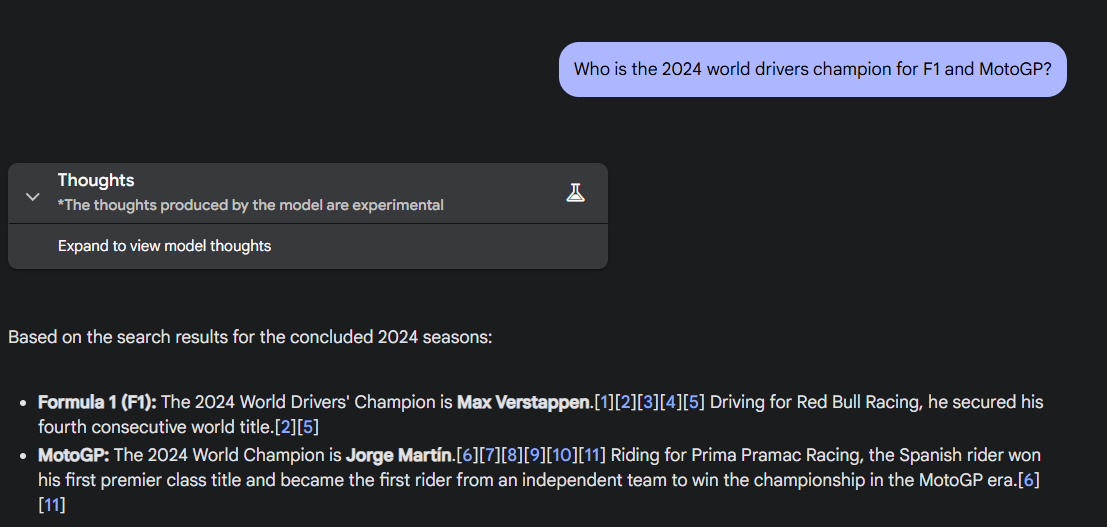
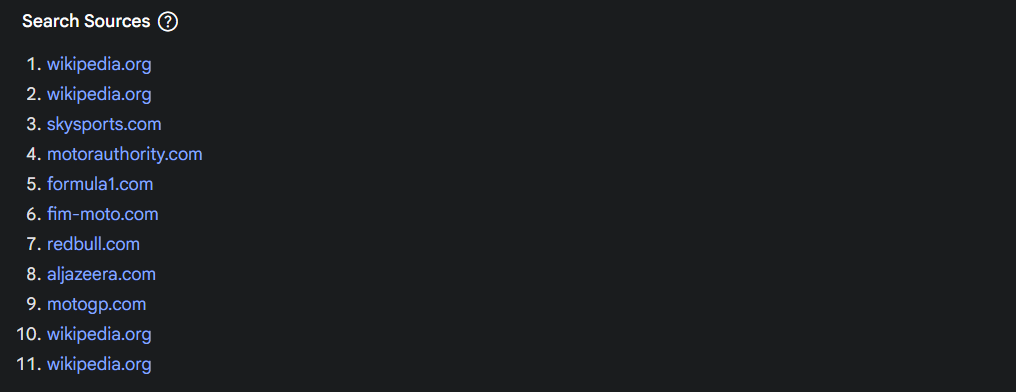
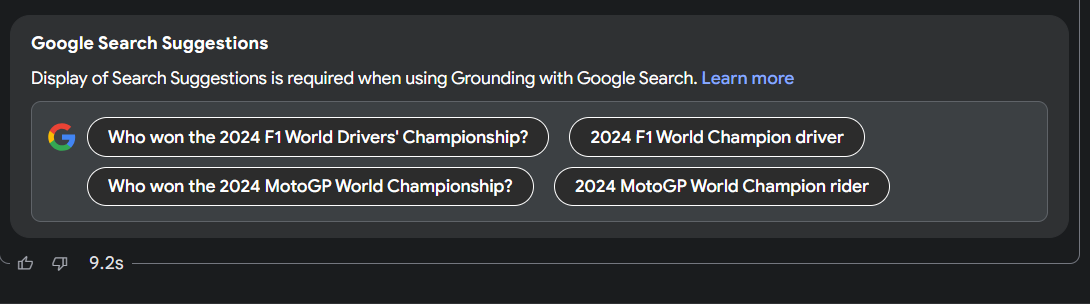

Very interesting indeed! You can try it out with your own questions and queries!😊

## Use the API

Start by installing and importing the Gemini API Python SDK.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

### Automated retry

In [4]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Use search grounding

### Model support

Search grounding is available in a limited set of models. Find a model that supports it on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this guide, you'll use `gemini-2.0-flash`.

### Make a request

To enable search grounding, you specify it as a tool: `google_search`. Like other tools, this is supplied as a parameter in `GenerateContentConfig`, and can be passed to `generate_content` calls as well as `chats.create` (for all chat turns) or `chat.send_message` (for specific turns).


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/app/prompts/1GTkO-gH4vd6G7LpBJ6Ay7U1OaJer7yDD"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [5]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I cannot provide you with a definitive answer on when and where Billie Eilish's next concert is. I don't have access to real-time information on tour schedules, which change frequently.

*   **Check Billie Eilish's Official Website:** The best place to find the most accurate and up-to-date tour dates is on her official website. Look for a "Tour" or "Events" section.
*   **Follow Her Social Media:** Billie Eilish and her team usually announce tour dates on her social media accounts (Instagram, Twitter/X, Facebook).
*   **Ticket Vendor Websites:** Ticketmaster, Live Nation, and other major ticket vendors will list her tour dates and ticket availability.

It is similar to ChatGPT when it was first released to the public. Now try with grounding enabled.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/14lDR0VjSni6BEUCZUBqj5PzTn3J194Th"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [6]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on April 23, 2025, at the Avicii Arena in Stockholm, Sweden. She also has another concert on April 24, 2025, at the same location.


### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [7]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALcyUD_fEVELhshpK8Hncp53hJGUrze-tEzvONIa0aB0Az2kKKZUXofEYAmOhIF2irGEdYYCoqOse7pufUHNLLYiiFFn0PBzRD4Zg6EICSG04-Ek-fJTE2b_nU7tdDkpCwSF7dtya0WqRFeGligqdToMZqUc-vYEpQMqRm0fWg=


As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [8]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The `grounding_supports` in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [9]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.60135436],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 162,
             'start_index': 93,
             'text': 'She also has another concert on April 24, 2025, at the '
                     'same location.'}}


These supports can be used to highlight text in the response, or build tables of footnotes.

In [10]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * She also has another concert on April 24, 2025, at the same location.<sup>[1]</sup>

Citations:

1. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALcyUD_fEVELhshpK8Hncp53hJGUrze-tEzvONIa0aB0Az2kKKZUXofEYAmOhIF2irGEdYYCoqOse7pufUHNLLYiiFFn0PBzRD4Zg6EICSG04-Ek-fJTE2b_nU7tdDkpCwSF7dtya0WqRFeGligqdToMZqUc-vYEpQMqRm0fWg=)


## Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [11]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

Now start a chat asking for some information. Here you provide the Google Search tool so that the model can look up data from Google's Search index.

In [17]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here is the medal tally for the top 10 countries at the 2024 Paris Olympics:

1.  **United States:** 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  **China:** 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  **France:** 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze (40 total)
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze (33 total)

----

In [22]:
#Wong's Edition
response2 = chat.send_message(
    message="What is the standings currently in formula 1 and motogp?",
    config=config_with_search,
)

show_response(response2)

Here are the current standings for Formula 1 and MotoGP as of April 4, 2025:

**Formula 1 (Top 10)**

1.  Lando Norris (McLaren): 44 points
2.  Max Verstappen (Red Bull Racing): 36 points
3.  George Russell (Mercedes): 35 points
4.  Oscar Piastri (McLaren): 34 points
5.  Kimi Antonelli (Mercedes): 22 points
6.  Alexander Albon (Williams): 16 points
7.  Esteban Ocon (Alpine): 10 points
8.  Lance Stroll (Aston Martin): 10 points
9.  Lewis Hamilton (Ferrari): 9 points
10. Charles Leclerc (Ferrari): 8 points

**MotoGP (Top 4)**

1.  Alex Marquez (BK8 Gresini Racing MotoGP): 87 points
2.  Marc Marquez (Ducati Lenovo Team): 86 points
3.  Francesco Bagnaia (Ducati Lenovo Team): 75 points
4.  Franco Morbidelli (Pertamina Enduro VR46 Racing): 55 points


----

Continuing the chat, now ask the model to convert the data into a chart. The `code_execution` tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the `executable_code` part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

In [23]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)

Okay, I can't directly *plot* a Seaborn chart for you within this text-based interface. I can, however, provide you with the Python code using Seaborn that you can then execute in a suitable environment (like a Jupyter Notebook, Google Colab, or a local Python script) to generate the visualizations.

Here's the code to create the charts you requested:



----

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Formula 1 Standings Data
f1_data = {
    'Driver': ['Lando Norris', 'Max Verstappen', 'George Russell', 'Oscar Piastri', 'Kimi Antonelli', 'Alexander Albon', 'Esteban Ocon', 'Lance Stroll', 'Lewis Hamilton', 'Charles Leclerc'],
    'Points': [44, 36, 35, 34, 22, 16, 10, 10, 9, 8]
}
f1_df = pd.DataFrame(f1_data)

# MotoGP Standings Data
motogp_data = {
    'Rider': ['Alex Marquez', 'Marc Marquez', 'Francesco Bagnaia', 'Franco Morbidelli'],
    'Points': [87, 86, 75, 55]
}
motogp_df = pd.DataFrame(motogp_data)

# Olympics Medal Data
olympics_data = {
    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],
    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],
    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],
    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8],
    'Total': [126, 91, 45, 53, 64, 34, 65, 32, 40, 33]
}
olympics_df = pd.DataFrame(olympics_data)

# --- Plotting ---

# Formula 1 Standings Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Points', y='Driver', data=f1_df, palette='viridis')
plt.title('Formula 1 Standings (April 4, 2025)')
plt.xlabel('Points')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

# MotoGP Standings Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x='Points', y='Rider', data=motogp_df, palette='magma')
plt.title('MotoGP Standings (April 4, 2025)')
plt.xlabel('Points')
plt.ylabel('Rider')
plt.tight_layout()
plt.show()

# Olympics Medal Tally - Stacked Bar Chart
olympics_df_melted = pd.melt(olympics_df, id_vars=['Country'], value_vars=['Gold', 'Silver', 'Bronze'], var_name='Medal', value_name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Country', y='Count', hue='Medal', data=olympics_df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors
plt.title('2024 Olympics Medal Tally')
plt.xlabel('Country')
plt.ylabel('Medal Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
```

----



**Explanation:**

1.  **Import Libraries:** Imports `pandas` for data manipulation, `seaborn` for plotting, and `matplotlib.pyplot` for showing the plots.
2.  **Data Creation:**  Creates Pandas DataFrames for Formula 1, MotoGP, and Olympics data.
3.  **Formula 1 Plot:**
    *   Creates a bar plot showing the points for each F1 driver.
    *   Uses `seaborn.barplot` for the visualization.
    *   Sets the title and labels.
4.  **MotoGP Plot:**
    *   Creates a bar plot showing the points for each MotoGP rider.
    *   Uses `seaborn.barplot` for the visualization.
    *   Sets the title and labels.
5.  **Olympics Plot (Stacked Bar):**
    *   Melts the `olympics_df` from a wide format to a long format using `pd.melt`. This is necessary for creating a stacked bar chart.
    *   Creates a stacked bar plot showing the gold, silver, and bronze medals for each country.
    *   Uses `seaborn.barplot` with `hue='Medal'` to create the stacking.
    *   Sets the title, labels, and rotates the x-axis labels for better readability.
    *   Specifies colors for Gold, Silver, and Bronze.
6.  **`plt.tight_layout()`:**  Adjusts subplot parameters to provide reasonable spacing between plots and labels.
7.  **`plt.show()`:** Displays the plots.

**To Use the Code:**

1.  **Install Libraries:**  If you don't have them already, install the necessary libraries:

    

----

```bash
    pip install pandas seaborn matplotlib
    ```

----



2.  **Copy and Paste:** Copy the Python code above.
3.  **Execute:** Paste the code into a Python environment (Jupyter Notebook, Google Colab, or a Python script) and run it.  The charts will be displayed.

This will generate three separate charts: bar charts for F1 and MotoGP standings, and a stacked bar chart for the Olympics medal tally. Let me know if you have any other questions.


----

Let us try out the code!

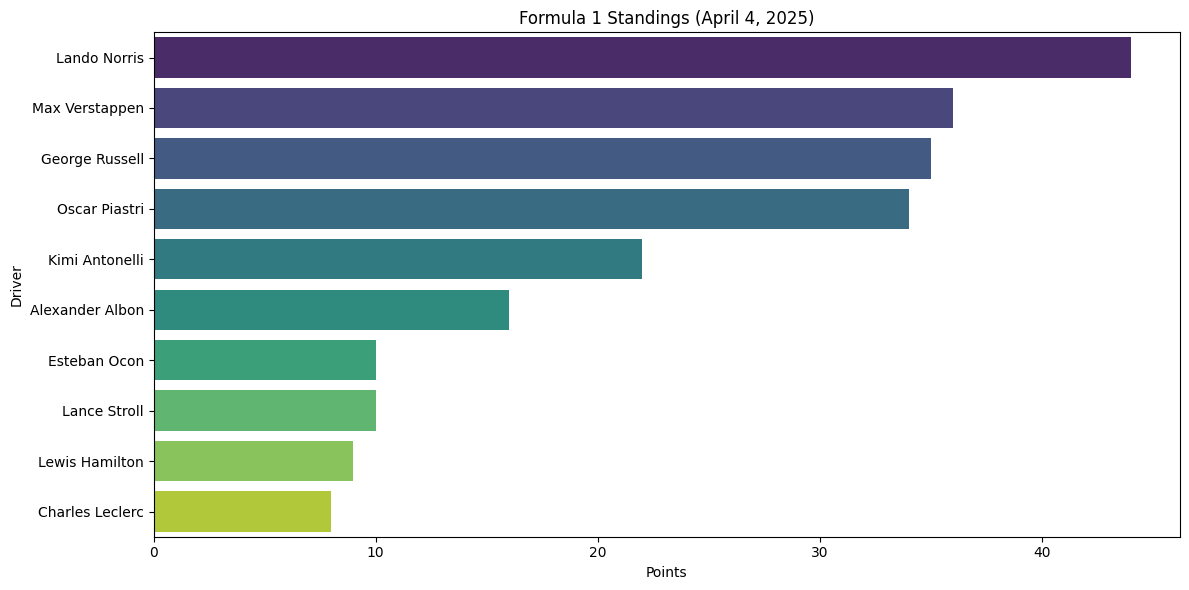

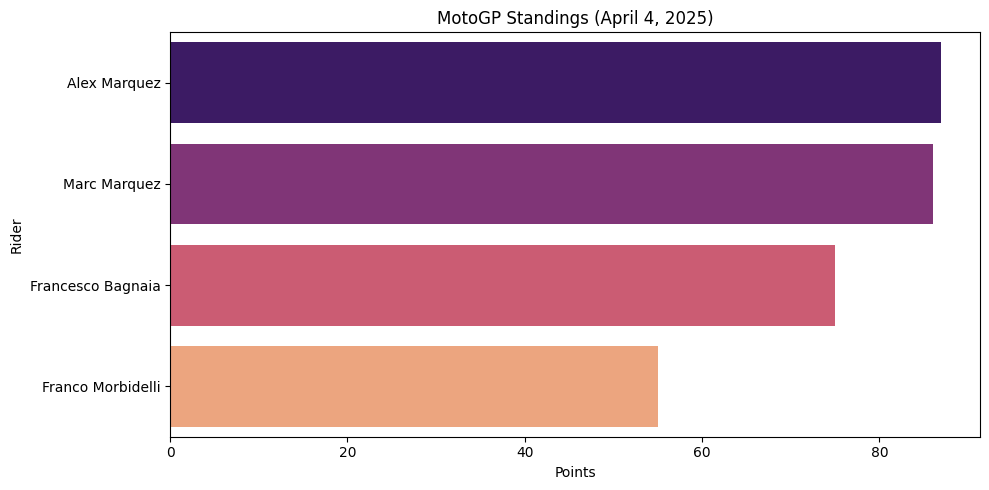

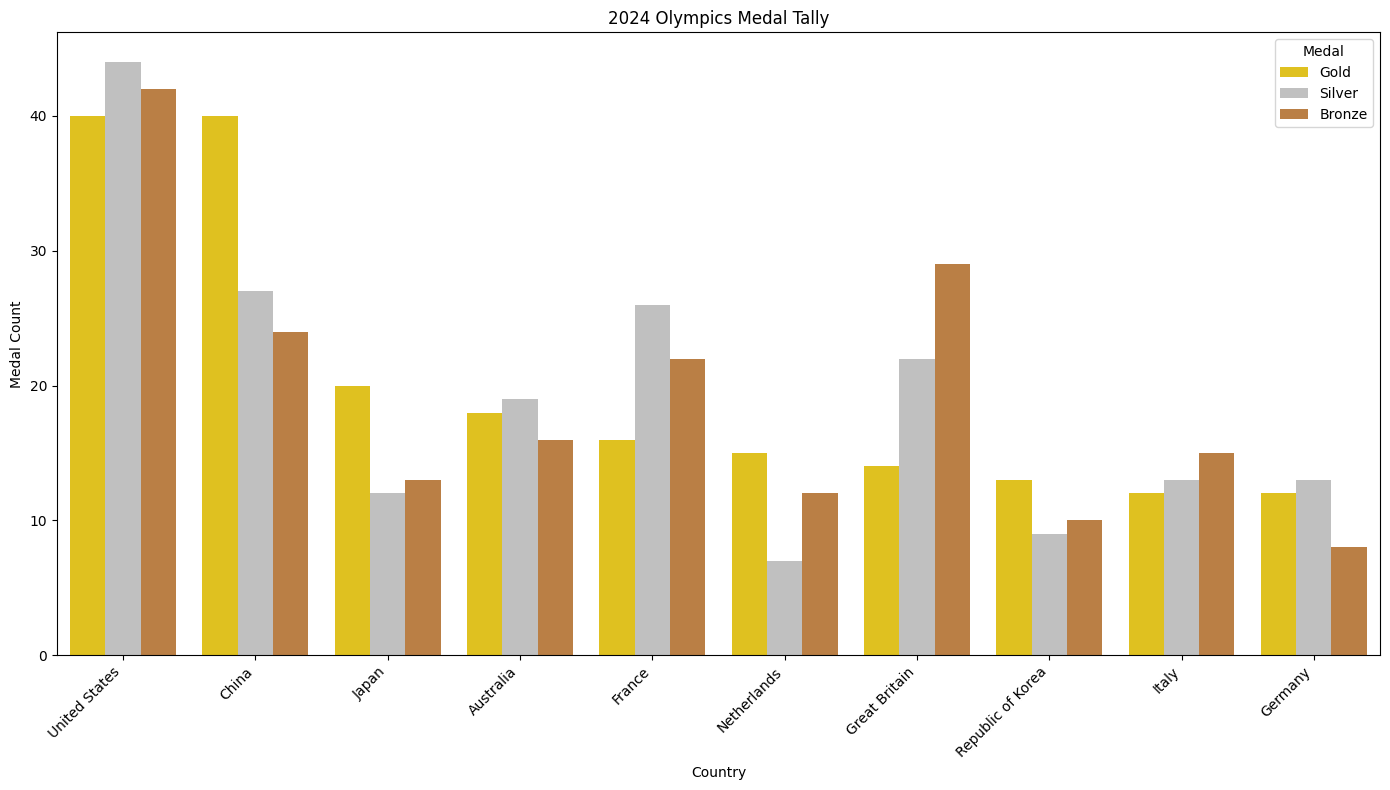

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Formula 1 Standings Data
f1_data = {
    'Driver': ['Lando Norris', 'Max Verstappen', 'George Russell', 'Oscar Piastri', 'Kimi Antonelli', 'Alexander Albon', 'Esteban Ocon', 'Lance Stroll', 'Lewis Hamilton', 'Charles Leclerc'],
    'Points': [44, 36, 35, 34, 22, 16, 10, 10, 9, 8]
}
f1_df = pd.DataFrame(f1_data)

# MotoGP Standings Data
motogp_data = {
    'Rider': ['Alex Marquez', 'Marc Marquez', 'Francesco Bagnaia', 'Franco Morbidelli'],
    'Points': [87, 86, 75, 55]
}
motogp_df = pd.DataFrame(motogp_data)

# Olympics Medal Data
olympics_data = {
    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],
    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],
    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],
    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8],
    'Total': [126, 91, 45, 53, 64, 34, 65, 32, 40, 33]
}
olympics_df = pd.DataFrame(olympics_data)

# --- Plotting ---

# Formula 1 Standings Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Points', y='Driver', data=f1_df, palette='viridis')
plt.title('Formula 1 Standings (April 4, 2025)')
plt.xlabel('Points')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

# MotoGP Standings Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x='Points', y='Rider', data=motogp_df, palette='magma')
plt.title('MotoGP Standings (April 4, 2025)')
plt.xlabel('Points')
plt.ylabel('Rider')
plt.tight_layout()
plt.show()

# Olympics Medal Tally - Stacked Bar Chart
olympics_df_melted = pd.melt(olympics_df, id_vars=['Country'], value_vars=['Gold', 'Silver', 'Bronze'], var_name='Medal', value_name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Country', y='Count', hue='Medal', data=olympics_df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors
plt.title('2024 Olympics Medal Tally')
plt.xlabel('Country')
plt.ylabel('Medal Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Impressive! That's how useful the the Gemini can be with Google Search Grounding and tools enabled at the same time!😄

## Further reading

When using search grounding, there are some specific requirements that you must follow, including when and how to show search suggestions, and how to use the grounding links.  Be sure to read and follow the details in the [search grounding capability guide](https://ai.google.dev/gemini-api/docs/grounding) and the [search suggestions guide](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions).

Also check out some more compelling examples of using search grounding with the Live API in the [cookbook](https://github.com/google-gemini/cookbook/), like [this example that uses Google Maps to plot Search results on a map](https://github.com/google-gemini/cookbook/blob/main/examples/LiveAPI_plotting_and_mapping.ipynb) in an audio conversation, or [this example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) that builds a comprehensive research report.

*- [Mark McD](https://linktr.ee/markmcd)*